# Visualization for Pseudo-Absence Generation

In this notebook the output of different pseudo-absence data generation techniques can be visualized.

In [1]:
# install.packages('comprehenr')
# install.packages("raster", dependencies=TRUE)
# install.packages('stringr')
# install.packages('ncdf4')
# install.packages('dplyr')
# install.packages("ggplot2")

In [2]:
library(raster)
library(ncdf4)
library(rgdal)
library(comprehenr)
library(glue)
library(stringr)
library(mopa)
library(dplyr)
library(ggplot2)
library(MASS)

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-27, (SVN revision 1148)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.4.0, released 2018/12/14
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-5


Attaching package: ‘glue’


The following object is masked from ‘package:raster’:

    trim



Attaching package: ‘dplyr’


The following object is masked from ‘package:glue’:

    collapse


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, 

In [71]:
env_profilers <- list('SoilMoi0_10cm_inst')
countries = ccodes()
african_countries <- countries[countries$continent == 'Africa',]$NAME


get_countrySPDF <- function(country)
{
    if (typeof(country) == 'list'){
        countrySPDF <- getData("GADM",country=country[[1]],level=0) 
        for (country_ in tail(country, -1)){
            countrySPDF <- raster::bind(countrySPDF, getData("GADM",country=country_[[1]],level=0))
        }
    } else if (typeof(country) == 'character'){
        countrySPDF <- getData("GADM",country=country,level=0)
    }
    return(countrySPDF)
}

subsetCountry <- function(country, data){
    countrySPDF <- get_countrySPDF(country)
    locs <- data.frame(x=data$x, y=data$y)
    coordinates(locs) <- c("x","y")
    projection(locs) <- CRS("+proj=longlat +init=epsg:4326")
    projection(countrySPDF) <- CRS("+proj=longlat +init=epsg:4326")
    countryID <- over(locs, countrySPDF)
    data_subset <- data
    data_subset['country'] <- countryID$NAME_0
    
    if (typeof(country) == 'list'){
        data_subset <- data_subset[data_subset$country %in% country,]
    } else if (typeof(country) == 'character'){
        data_subset <- data_subset[data_subset$country == country,]
    }
    
    return(data_subset)
}

cropCountry <- function(baseRaster, country)
{
    countrySPDF <- get_countrySPDF(country)
    croppedRaster <- mask(crop(baseRaster, extent(countrySPDF)), countrySPDF)
    return(croppedRaster)
}

aggregateSM_NASA <- function(year, month, basePath, env_profilers){
    base_name <- glue("{basePath}/GLDAS_NOAH025_3H.A{year}{str_pad(month, width=2, pad='0')}")
    dekad1 <- unlist(to_list(for (day in 1:10) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))
    dekad2 <- unlist(to_list(for (day in 11:20) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))
    dekad3 <- unlist(to_list(for (day in 21:31) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))
    dekad1_stacks <- list()
    dekad2_stacks <- list()
    dekad3_stacks <- list()
    i <- 1
    for (env_variable in env_profilers){
        dekad1_stacks[[i]] <- calc(stack(dekad1, varname=env_variable), mean)
        dekad2_stacks[[i]] <- calc(stack(dekad2, varname=env_variable), mean)
        dekad3_stacks[[i]] <- calc(stack(dekad3, varname=env_variable), mean)
        i <- i + 1
    }
    dekad1_stacks <- stack(dekad1_stacks)
    names(dekad1_stacks) <- paste0(env_profilers, "_dekad1")
    dekad2_stacks <- stack(dekad2_stacks)
    names(dekad2_stacks) <- paste0(env_profilers, "_dekad2")
    dekad3_stacks <- stack(dekad3_stacks)
    names(dekad3_stacks) <- paste0(env_profilers, "_dekad3")
    
    sm <- stack(dekad1_stacks, dekad2_stacks, dekad3_stacks)
    return(sm)
}
                             

get_soil_profile <- function(basePath) {
    clay0_5 <- raster(glue('{basePath}/clay_0-5cm_mean.tif'))
    clay5_15 <- raster(glue('{basePath}/clay_5-15cm_mean.tif'))
    sand0_5 <- raster(glue('{basePath}/sand_0-5cm_mean.tif'))
    sand5_15 <- raster(glue('{basePath}/sand_5-15cm_mean.tif'))
    silt0_5 <- raster(glue('{basePath}/silt_0-5cm_mean.tif'))
    silt5_15 <- raster(glue('{basePath}/silt_5-15cm_mean.tif'))
    soil_profile <- stack(c(clay0_5, clay5_15, sand0_5, sand5_15, silt0_5, silt5_15))
    return(soil_profile)
}

In [5]:
swarms_fao_data <- read.csv(file = 'Hoppers.csv')
head(swarms_fao_data)

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,⋯,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT
,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,37.333333,19.31667,1,1985/12/30 00:00:00+00,12:00,1985/12/30 00:00:00+00,12:00,No,Late,Khor Hambokeib,⋯,,0,,0,0,0,0,0,0,Hopper
2,37.350000,19.23333,2,1985/12/30 00:00:00+00,12:00,1985/12/30 00:00:00+00,12:00,No,Late,Khor Handub,⋯,,0,,0,0,0,0,0,0,Hopper
3,-14.917778,16.95167,3,1985/10/18 00:00:00+00,12:00,1985/10/18 00:00:00+00,12:00,No,Middle,,⋯,,0,,0,0,0,0,0,0,Hopper
4,-0.381650,18.66083,4,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,⋯,,0,,0,0,0,0,0,0,Hopper
5,1.522778,20.93833,5,1985/11/06 00:00:00+00,12:00,1985/11/06 00:00:00+00,12:00,No,Early,,⋯,,0,,0,0,0,0,0,0,Hopper
6,4.216111,18.63500,6,1985/11/15 00:00:00+00,12:00,1985/11/15 00:00:00+00,12:00,Yes,,,⋯,,0,,0,0,0,0,0,0,Hopper


In [8]:
country <- list('Mauritania', 'Mali')
country_data <- swarms_fao_data
date <- as.POSIXct(country_data[['STARTDATE']], format = "%Y/%m/%d %H:%M:%S")
country_data[['yearmonth']] <- format(date, format="%Y%m")
country_data[['year']] <- format(date, format="%Y")
country_data[['month']] <- format(date, format="%m")
country_data[['day']] <- format(date, format="%d")

In [9]:
unique(country_data$COUNTRY)

[1] SU MR ML AG NG ER SA IN SG SO PA MO YE CD IR EG ET AA GA WI CV DJ TS JO OM
[26] AE    LY IS MU MA YM KU PK KE IQ SS CR TD SD LE
41 Levels:   AA AE AG CD CR CV DJ EG ER ET GA IN IQ IR IS JO KE KU LE LY ... YM

In [10]:
unique(country_data$year)

[1] "1985" "1986" "1987" "1988" "1989" "1990" "1991" "1992" "1993" "1994"
[11] "1995" "1996" "1997" "1998" "1999" "2000" "2001" "2002" "2003" "2004"
[21] "2005" "2006" "2007" "2008" "2009" "2010" "2011" "2012" "2013" "2014"
[31] "2015" "2016" "2017" "2018" "2019" "2020" "2021"

In [11]:
fao_yearmonths <- as.numeric(unique(country_data$yearmonth))
nasa_yearmonths <- fao_yearmonths[fao_yearmonths >= 200000 & fao_yearmonths <= 201100]

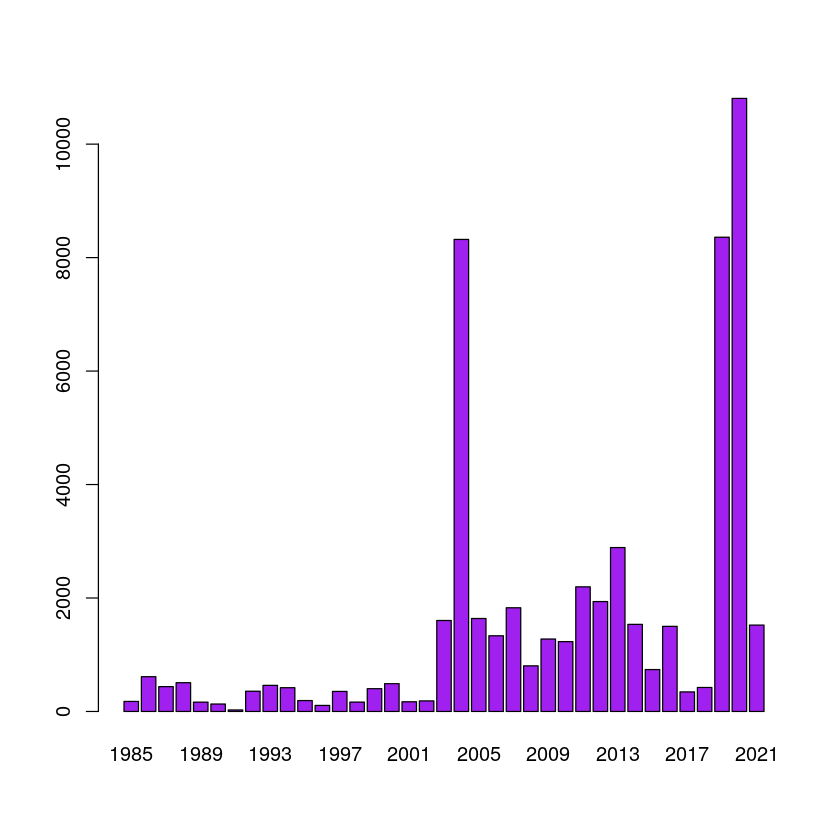

In [12]:
barplot(table(country_data$year), col= "purple")

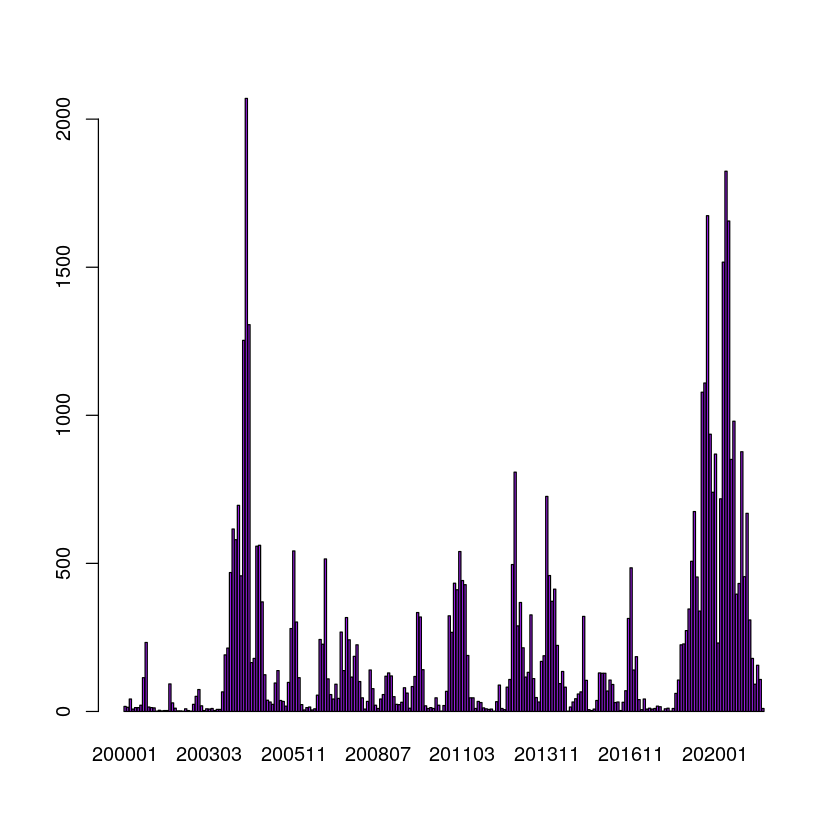

In [13]:
barplot(table(country_data[(country_data$year >= 2000),]$yearmonth), col= "purple")

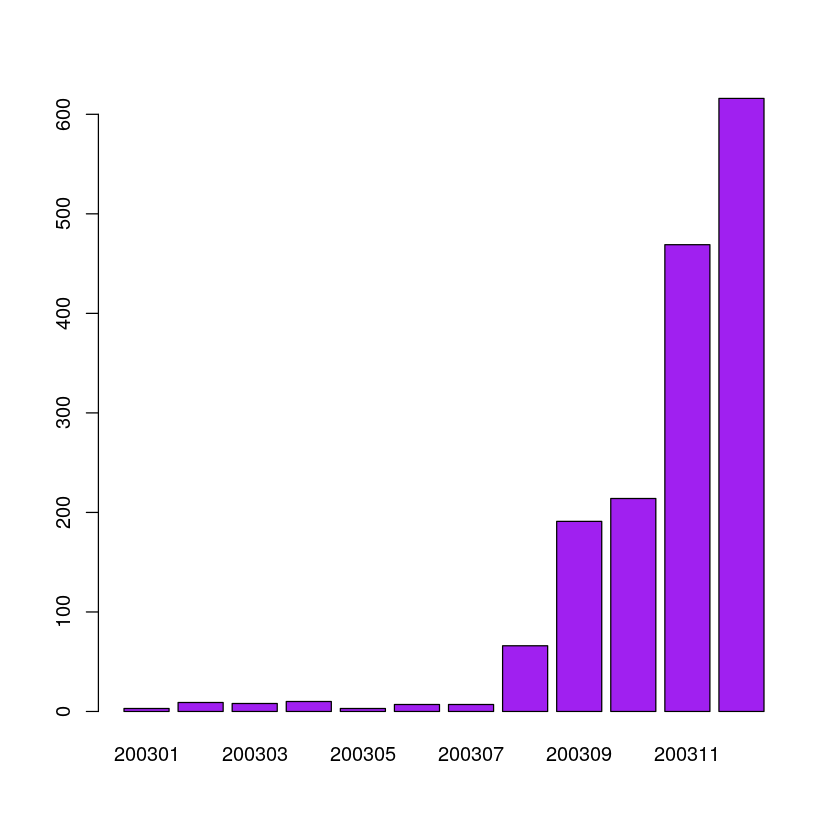

In [20]:
subset_year <- country_data[country_data$year == '2003',]
barplot(table(subset_year$yearmonth), col= "purple")

## Visualize PA Generation

In [67]:
yearmonth  <- 200311
                             
month <- yearmonth %% 100
year <- yearmonth %/% 100

country <- as.list(african_countries)
countrySPDF <- get_countrySPDF(country)
env_data <- cropCountry(aggregateSM_NASA(year, month, NASA_basePath, env_profilers), country)

dataset <- read.csv(file = 'Hoppers.csv')
date <- as.POSIXct(dataset[['STARTDATE']], format = "%Y/%m/%d %H:%M:%S")
dataset[['yearmonth']] <- format(date, format="%Y%m")
dataset[['year']] <- as.numeric(format(date, format="%Y"))
dataset[['month']] <- as.numeric(format(date, format="%m"))
dataset[['day']] <- as.numeric(format(date, format="%d"))
train_val <- dataset[((dataset$year >= 2000) & (dataset$year < 2015)),]
train_val['y'] <- train_val$Y
train_val['x'] <- train_val$X

train_val_subset <- subsetCountry(country, train_val)
data_subset <- train_val_subset[(train_val_subset$yearmonth == as.character(yearmonth)),]
presence <- data_subset[(data_subset$LOCPRESENT == 1),]
true_absence <- data_subset[(data_subset$LOCPRESENT == 2),]
geo_locs <- data.frame(x=presence$X, y=presence$Y)
geo_locs_len <- dim(geo_locs)[1]
bg <- backgroundGrid(env_data)

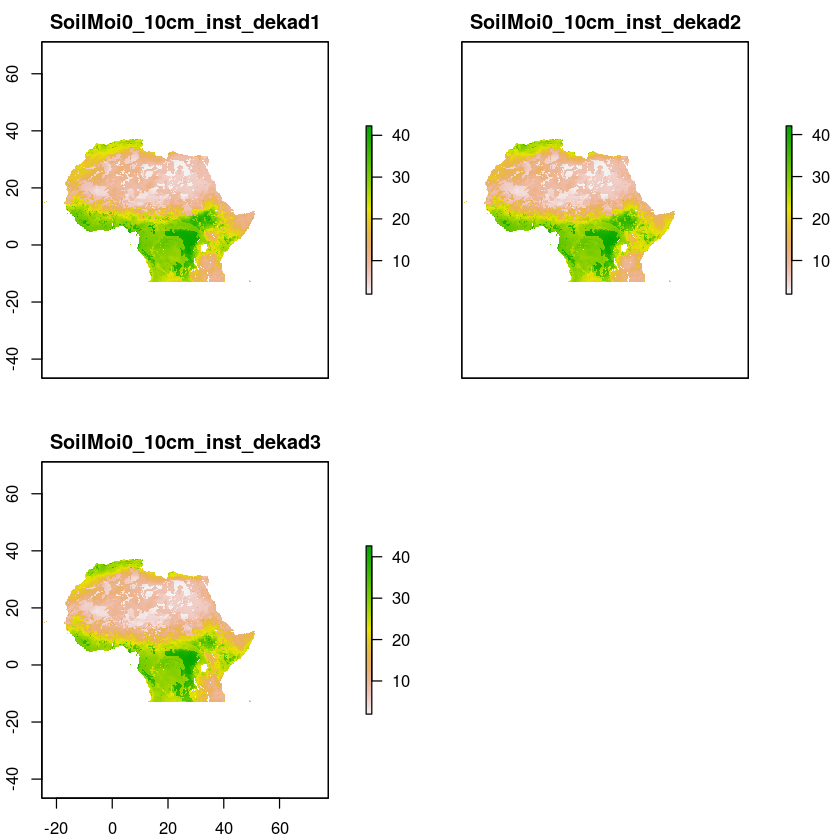

In [40]:
plot(env_data)

In [41]:
bg_extents <- backgroundRadius(xy = geo_locs, background = bg$xy, 
       start = 0.083*3, by = 0.083*3, 
       unit = "decimal degrees")
random_generated_data <-pseudoAbsences(xy = geo_locs, background = bg$xy, 
               exclusion.buffer = 0.083*3, 
               prevalence = 0.5, kmeans = FALSE)

random_plus_generated_data <-pseudoAbsences(xy = geo_locs, background = bg_extents, 
                                       exclusion.buffer = 0.083*3, 
                                       prevalence = 0.5, kmeans = FALSE)

[1] "creating background point-grids for species 1 out of 1"


[2021-12-02 16:30:13] Generating pseudo-absences for species 1

:::[2021-12-02 16:30:13] Realization 1

[2021-12-02 16:30:15] Generating pseudo-absences for species 1

:::[2021-12-02 16:30:15] Realization 1

Background km30 is too small for sampling and will be ignored



In [42]:
bg_profiled <- OCSVMprofiling(xy = geo_locs, 
                varstack = calc(raster::subset(env_data, c('SoilMoi0_10cm_inst_dekad1', 'SoilMoi0_10cm_inst_dekad2', 'SoilMoi0_10cm_inst_dekad3')), mean), 
                background = bg$xy)
bg_extents <- backgroundRadius(xy = geo_locs, background = bg_profiled$absence, 
       start = 0.083*3, by = 0.083*3, 
       unit = "decimal degrees")
# generate data using environmental profiling
ep_random_generated_data <-pseudoAbsences(xy = geo_locs, background = bg_profiled$absence, 
                   exclusion.buffer = 0.083*3, 
                   prevalence = 0.5, kmeans = FALSE)

ep_random_plus_generated_data <-pseudoAbsences(xy = geo_locs, background = bg_extents, 
                   exclusion.buffer = 0.083*3, 
                   prevalence = 0.5, kmeans = FALSE)


[1] "creating background point-grids for species 1 out of 1"


[2021-12-02 16:30:28] Generating pseudo-absences for species 1

:::[2021-12-02 16:30:28] Realization 1

[2021-12-02 16:30:30] Generating pseudo-absences for species 1

:::[2021-12-02 16:30:30] Realization 1

Background km30 is too small for sampling and will be ignored

Background km60 is too small for sampling and will be ignored



Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


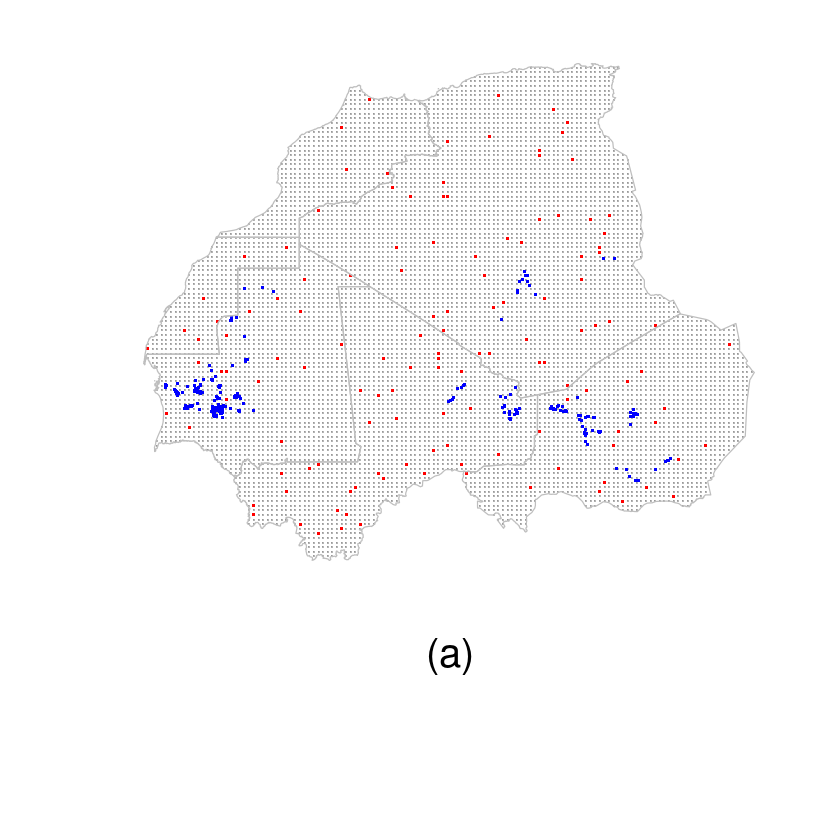

In [72]:
#pdf(file = "plots/rs.pdf")
par(mar=c(11,3.5,2,1))

country <- list('Niger', 'Mauritania', 'Mali', 'Algeria', 'Western Sahara', 'Morocco')
background_to_plot <- subsetCountry(country, data.frame(bg$xy))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.25, 
     axes=FALSE, bty="n", xlab="(a)", ylab='', cex.lab=2.0,)

data_to_plot <- subsetCountry(country, random_generated_data$species1$PA01[[1]])


points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


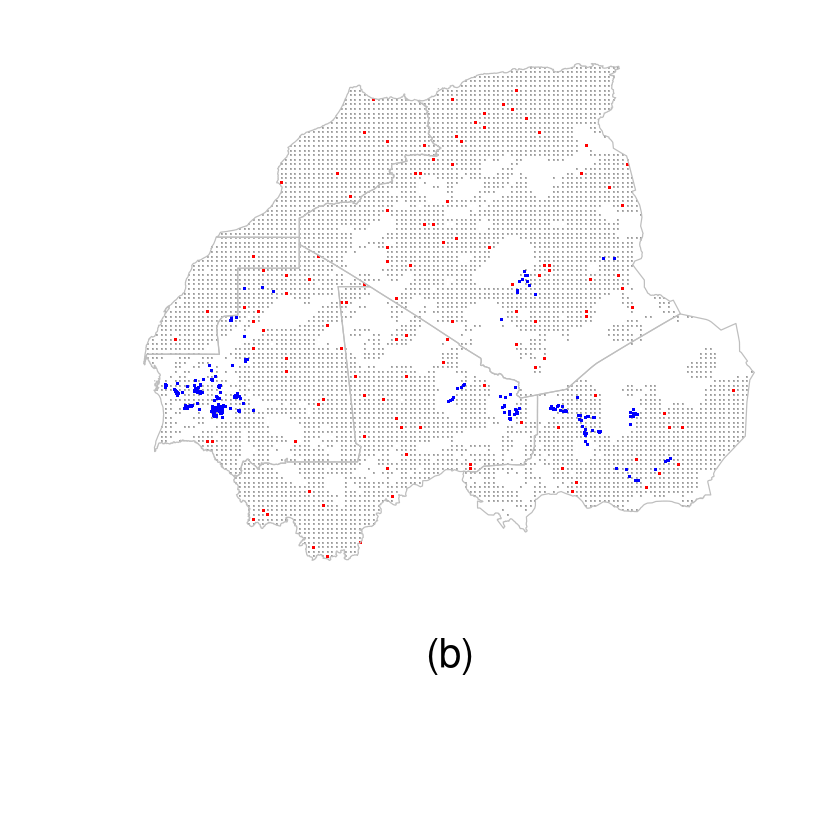

In [78]:
# pdf(file = "plots/rsep.pdf")
par(mar=c(11,3.5,2,1))

country <- list('Niger', 'Mauritania', 'Mali', 'Algeria', 'Western Sahara', 'Morocco')
background_to_plot <- subsetCountry(country, data.frame(bg_profiled$absence))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.25, 
     axes=FALSE, bty="n", xlab="(b)", ylab='', cex.lab=2.0,)

data_to_plot <- subsetCountry(country, ep_random_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


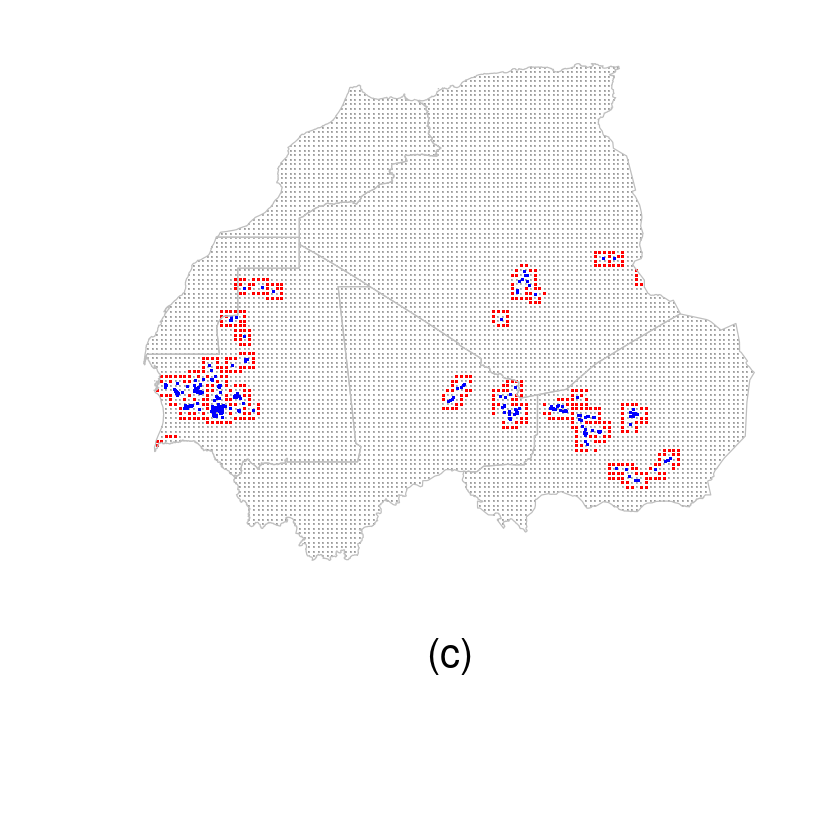

In [79]:
# pdf(file = "plots/rs_plus.pdf")
par(mar=c(11,3.5,2,1))

country <- list('Niger', 'Mauritania', 'Mali', 'Algeria', 'Western Sahara', 'Morocco')
background_to_plot <- subsetCountry(country, data.frame(bg$xy))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.25, 
     axes=FALSE, bty="n", xlab="(c)", ylab='', cex.lab=2.0,)

data_to_plot <- subsetCountry(country, random_plus_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


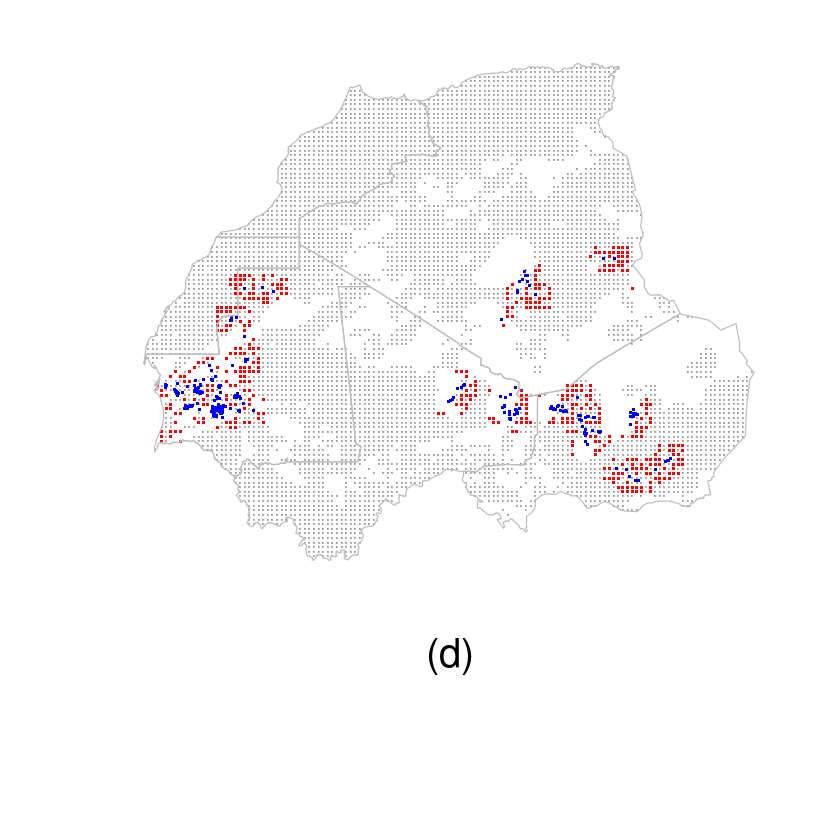

In [80]:
# pdf(file = "plots/rsep_plus.pdf")
par(mar=c(11,3.5,2,1))

country <- list('Niger', 'Mauritania', 'Mali', 'Algeria', 'Western Sahara', 'Morocco')
background_to_plot <- subsetCountry(country, data.frame(bg_profiled$absence))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.25, 
     axes=FALSE, bty="n", xlab="(d)", ylab='', cex.lab=2.0,)

data_to_plot <- subsetCountry(country, ep_random_plus_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


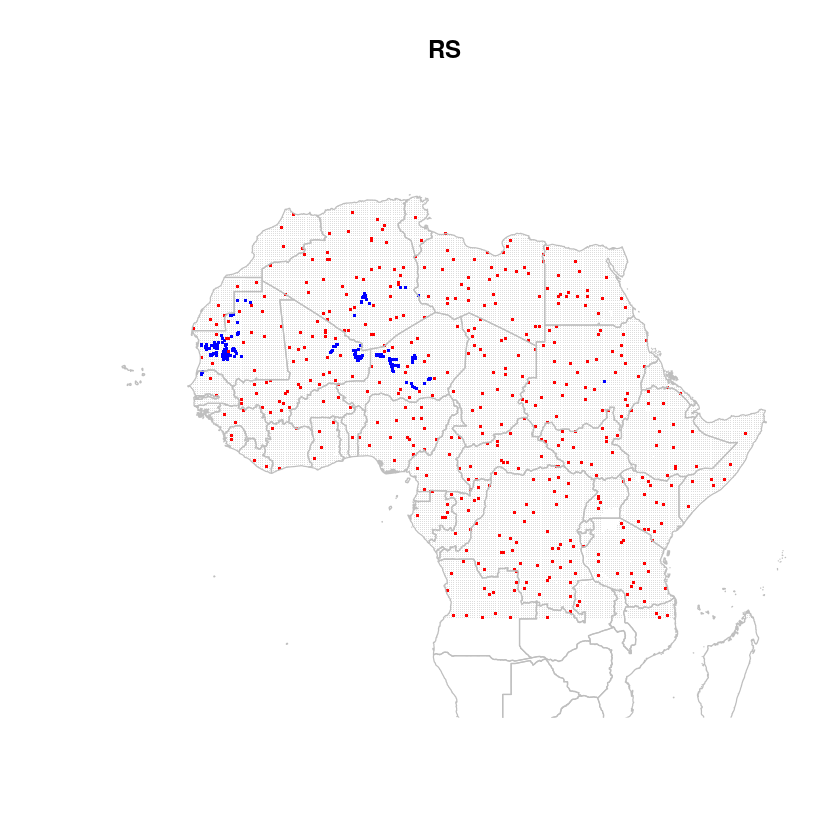

In [81]:
#pdf(file = "plots/rs.pdf")
# par(mar=c(11,3.5,2,1))

country <- as.list(african_countries)
background_to_plot <- subsetCountry(country, data.frame(bg$xy))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.05, 
     axes=FALSE, bty="n", xlab='', ylab='', cex.lab=2.0,, main='RS')

data_to_plot <- subsetCountry(country, random_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


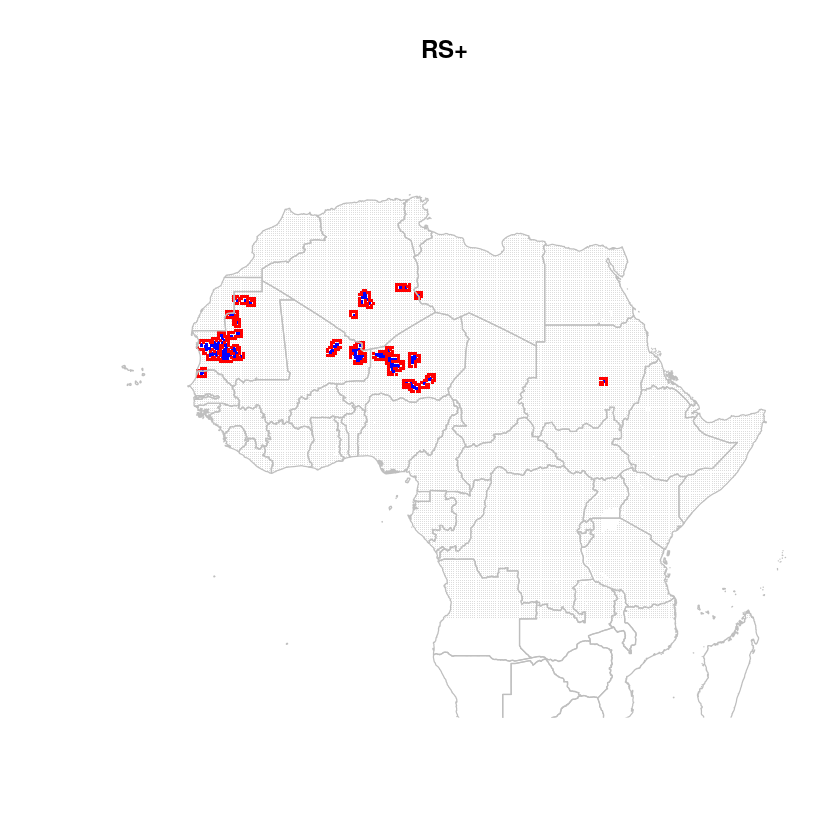

In [82]:
# pdf(file = "plots/rs_plus.pdf")
# par(mar=c(11,3.5,2,1))

country <- as.list(african_countries)
background_to_plot <- subsetCountry(country, data.frame(bg$xy))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.05, 
     axes=FALSE, bty="n", xlab='', ylab='', cex.lab=2.0, main='RS+')

data_to_plot <- subsetCountry(country, random_plus_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


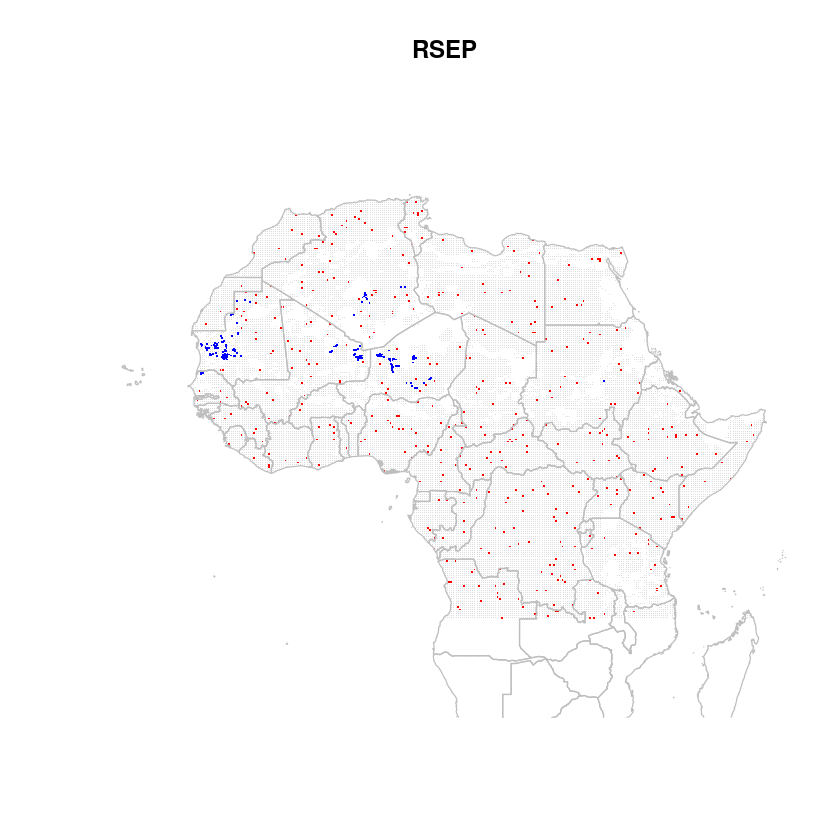

In [83]:
# pdf(file = "plots/rsep.pdf")
# par(mar=c(11,3.5,2,1))

country <- as.list(african_countries)
background_to_plot <- subsetCountry(country, data.frame(bg_profiled$absence))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.05, axes=FALSE, bty="n", 
     xlab='', ylab='', cex.lab=2.0, main="RSEP")

data_to_plot <- subsetCountry(country, ep_random_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 1.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 1.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()

Warning message in data.matrix(x):
“NAs introduced by coercion”
Warning message in data.matrix(x):
“NAs introduced by coercion”


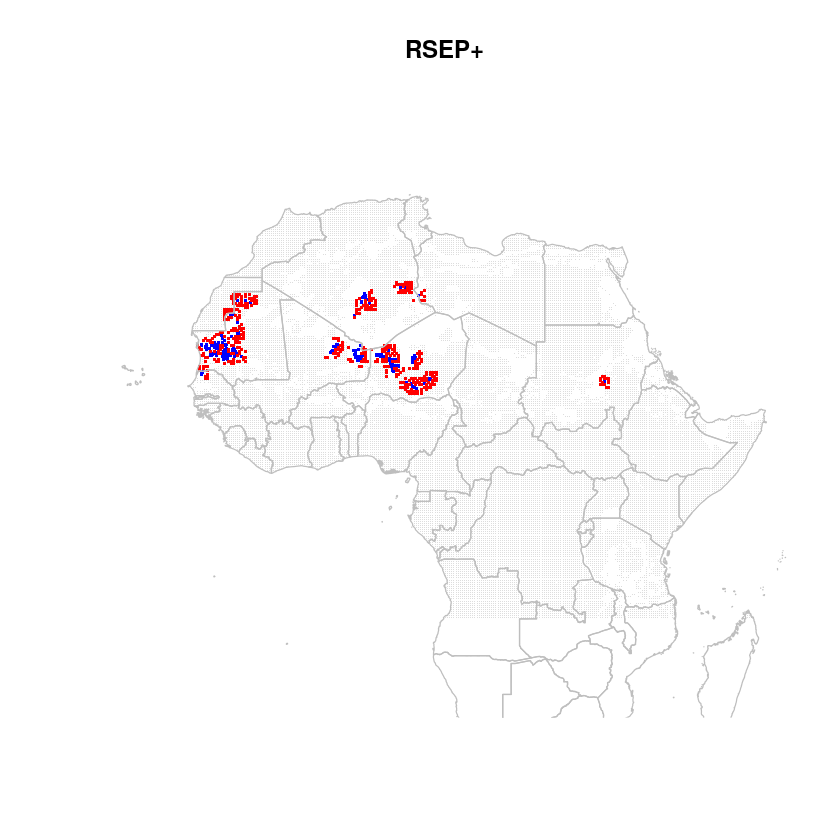

In [84]:
# pdf(file = "plots/rsep_plus.pdf")
# par(mar=c(11,3.5,2,1))

country <- as.list(african_countries)
background_to_plot <- subsetCountry(country, data.frame(bg_profiled$absence))
background_to_plot <- data.frame(x=background_to_plot$x, y=background_to_plot$y)

plot(background_to_plot, pch="*", asp = 1, cex = 0.05, 
     axes=FALSE, bty="n", xlab='', ylab='', cex.lab=2.0, main="RSEP+")

data_to_plot <- subsetCountry(country, ep_random_plus_generated_data$species1$PA01[[1]])

points(filter(data_to_plot, v == 1), col= "blue", pch = ".", cex = 2.5)
points(filter(data_to_plot, v == 0), col= "red", pch = ".", cex = 2.5)
plot(get_countrySPDF(country), add=TRUE, cex = 0.05, border='grey')

# dev.off()